In [1]:
from pathlib import Path

dataset_path = Path(r'/home/thor/Desktop/datasets/kdef/original/KDEF-HRS-organized421414-cropped16400')

training_set_path = dataset_path / 'training_set'
validation_set_path = dataset_path / 'validation_set'
test_set_path = dataset_path / 'test_set'

id_to_emotion = {
    0: 'Neutral',
    1: 'Happy',
    2: 'Sad',
    3: 'Surprise',
    4: 'Fear',
    5: 'Disgust',
    6: 'Anger',
}


In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)
SEED = 42

In [3]:
def compute_class_frequencies(dataset_path: Path) -> dict:
    class_frequencies = {}
    for class_dir in sorted(dataset_path.iterdir()):
        num_files = sum(1 for _ in class_dir.iterdir())
        class_id = int(class_dir.name)
        class_frequencies[class_id] = num_files
        print(f'{class_id} - {id_to_emotion[class_id]:<9} : {num_files:>8} images')

    return class_frequencies


In [4]:
import keras

print('---TRAINING SET---')
training_set = keras.preprocessing.image_dataset_from_directory(training_set_path,
                                                                batch_size=BATCH_SIZE,
                                                                image_size=IMAGE_SIZE,
                                                                shuffle=True,
                                                                seed=SEED)

class_frequencies = compute_class_frequencies(training_set_path)


2024-03-20 13:44:10.586695: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-20 13:44:10.607555: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-20 13:44:10.607576: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-20 13:44:10.608113: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-20 13:44:10.611614: I tensorflow/core/platform/cpu_feature_guar

---TRAINING SET---
Found 1175 files belonging to 7 classes.


2024-03-20 13:44:11.507153: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-20 13:44:11.526059: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-20 13:44:11.526170: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

0 - Neutral   :      167 images
1 - Happy     :      168 images
2 - Sad       :      168 images
3 - Surprise  :      168 images
4 - Fear      :      168 images
5 - Disgust   :      168 images
6 - Anger     :      168 images


In [5]:
print('---VALIDATION SET---')
validation_set = keras.preprocessing.image_dataset_from_directory(validation_set_path,
                                                                  batch_size=BATCH_SIZE,
                                                                  image_size=IMAGE_SIZE,
                                                                  shuffle=True,
                                                                  seed=SEED)

compute_class_frequencies(validation_set_path)


---VALIDATION SET---
Found 391 files belonging to 7 classes.
0 - Neutral   :       56 images
1 - Happy     :       56 images
2 - Sad       :       56 images
3 - Surprise  :       55 images
4 - Fear      :       56 images
5 - Disgust   :       56 images
6 - Anger     :       56 images


{0: 56, 1: 56, 2: 56, 3: 55, 4: 56, 5: 56, 6: 56}

In [6]:
total_num_samples = sum(class_frequencies.values())
inverse_class_frequencies = {class_id: 1 / (frequency / total_num_samples) for class_id, frequency in
                             class_frequencies.items()}

total_inverse_class_frequencies = sum(inverse_class_frequencies.values())
class_weights = {class_id: freq / total_inverse_class_frequencies for class_id, freq in
                 inverse_class_frequencies.items()}

print(class_weights)


{0: 0.14358974358974358, 1: 0.1427350427350427, 2: 0.1427350427350427, 3: 0.1427350427350427, 4: 0.1427350427350427, 5: 0.1427350427350427, 6: 0.1427350427350427}


In [7]:
from keras import layers
from keras.models import Sequential

data_augmentation = Sequential([
    layers.RandomFlip(mode="horizontal"),
    layers.RandomTranslation(height_factor=0.05, width_factor=0.05, fill_mode="constant"),
    layers.RandomRotation(0.1, fill_mode="constant"),
    layers.RandomZoom(0.1, fill_mode="constant"),
    layers.RandomContrast(0.1),
    layers.RandomBrightness(0.1)
])

inputs = layers.Input(shape=(*IMAGE_SIZE, 3))
x = data_augmentation(inputs)


In [8]:
from keras.src.applications import EfficientNetB0


def build_model(num_classes, inputs_layer):
    model = EfficientNetB0(include_top=False, input_tensor=inputs_layer, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    # x = layers.BatchNormalization()(x)
    # x = layers.Dense(512, activation="relu")(x)
    x = layers.Dropout(0.2, name="top_dropout1")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)

    # Compile
    return keras.Model(inputs, outputs, name="EfficientNet")
    

model = build_model(len(class_frequencies), x)
model.summary()

Model: "EfficientNet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 sequential (Sequential)     (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['sequential[0][0]']          
                                                                                                  
 normalization (Normalizati  (None, 224, 224, 3)          7         ['rescaling[0][0]']           
 on)                                                                                   

In [9]:
num_layers = len(model.layers)
for i, layer in enumerate(model.layers):
    print((num_layers - i), layer.name, layer.__class__.__name__)

242 input_1 InputLayer
241 sequential Sequential
240 rescaling Rescaling
239 normalization Normalization
238 rescaling_1 Rescaling
237 stem_conv_pad ZeroPadding2D
236 stem_conv Conv2D
235 stem_bn BatchNormalization
234 stem_activation Activation
233 block1a_dwconv DepthwiseConv2D
232 block1a_bn BatchNormalization
231 block1a_activation Activation
230 block1a_se_squeeze GlobalAveragePooling2D
229 block1a_se_reshape Reshape
228 block1a_se_reduce Conv2D
227 block1a_se_expand Conv2D
226 block1a_se_excite Multiply
225 block1a_project_conv Conv2D
224 block1a_project_bn BatchNormalization
223 block2a_expand_conv Conv2D
222 block2a_expand_bn BatchNormalization
221 block2a_expand_activation Activation
220 block2a_dwconv_pad ZeroPadding2D
219 block2a_dwconv DepthwiseConv2D
218 block2a_bn BatchNormalization
217 block2a_activation Activation
216 block2a_se_squeeze GlobalAveragePooling2D
215 block2a_se_reshape Reshape
214 block2a_se_reduce Conv2D
213 block2a_se_expand Conv2D
212 block2a_se_excite M

In [10]:
def unfreeze_model(model, num_layers):
    for layer in model.layers[-num_layers:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

In [11]:
import datetime
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M")
checkpoint_dir = Path(f"kdef_transfer_imagenet_{timestamp}")
training_histories = []
epoch_counter = 0
epochs_per_phase = [20, 20, 20, 20, 40, 10]
layers_to_unfreeze_per_phase = [3, 19, 78, 194, len(model.layers), len(model.layers)]
learning_rate_per_phase = [1e-3, 1e-3, 1e-3, 1e-4, 1e-5, 1e-6]

for phase, (epochs, layers_to_unfreeze, learning_rate) in enumerate(
        zip(epochs_per_phase, layers_to_unfreeze_per_phase, learning_rate_per_phase)):

    print(f'\n---STARTING TRAINING PHASE {phase}')
    print(f'EPOCHS:{epochs} LAYERS_TO_UNFREEZE:{layers_to_unfreeze} LEARNING_RATE:{learning_rate}')
    checkpoint_filepath = str(checkpoint_dir / f'best_model_phase_{phase}.keras')

    model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath,
                                                save_weights_only=False,
                                                monitor='val_accuracy',
                                                mode='max',
                                                save_best_only=True)

    if phase > 0:
        old_checkpoint_filepath = checkpoint_filepath.replace(f'phase_{phase}', f'phase_{phase - 1}')
        print(f'Loading model from {old_checkpoint_filepath}')
        model = load_model(old_checkpoint_filepath)
        
    unfreeze_model(model, layers_to_unfreeze)
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])

    hist = model.fit(training_set,
                     epochs=epoch_counter + epochs,
                     validation_data=validation_set,
                     class_weight=class_weights,
                     callbacks=[model_checkpoint_callback],
                     initial_epoch=epoch_counter)

    epoch_counter += epochs
    training_histories.append(hist)


---STARTING TRAINING PHASE 0
EPOCHS:20 LAYERS_TO_UNFREEZE:3 LEARNING_RATE:0.001
Epoch 1/20


2024-03-20 13:44:18.857671: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-03-20 13:44:18.949062: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


 3/37 [=>............................] - ETA: 0s - loss: 0.2936 - accuracy: 0.1042  

2024-03-20 13:44:19.523939: I external/local_xla/xla/service/service.cc:168] XLA service 0x702176d10ff0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-20 13:44:19.523953: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-03-20 13:44:19.529932: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1710938659.592123    5775 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


37/37 [==============================] - 8s 72ms/step - loss: 0.2785 - accuracy: 0.1787 - val_loss: 1.9126 - val_accuracy: 0.1688
Epoch 2/20
37/37 [==============================] - 2s 44ms/step - loss: 0.2645 - accuracy: 0.2613 - val_loss: 1.8323 - val_accuracy: 0.2174
Epoch 3/20
37/37 [==============================] - 2s 41ms/step - loss: 0.2527 - accuracy: 0.3149 - val_loss: 1.7027 - val_accuracy: 0.3734
Epoch 4/20
37/37 [==============================] - 2s 40ms/step - loss: 0.2404 - accuracy: 0.3881 - val_loss: 1.6255 - val_accuracy: 0.4118
Epoch 5/20
37/37 [==============================] - 1s 34ms/step - loss: 0.2331 - accuracy: 0.3838 - val_loss: 1.5985 - val_accuracy: 0.4041
Epoch 6/20
37/37 [==============================] - 2s 44ms/step - loss: 0.2278 - accuracy: 0.4221 - val_loss: 1.5471 - val_accuracy: 0.4143
Epoch 7/20
37/37 [==============================] - 1s 34ms/step - loss: 0.2216 - accuracy: 0.4494 - val_loss: 1.5189 - val_accuracy: 0.4118
Epoch 8/20
37/37 [======

2024-03-20 13:44:56.034369: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inEfficientNet/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


37/37 [==============================] - 8s 71ms/step - loss: 0.1928 - accuracy: 0.5004 - val_loss: 0.8867 - val_accuracy: 0.6982
Epoch 22/40
37/37 [==============================] - 2s 42ms/step - loss: 0.1172 - accuracy: 0.7055 - val_loss: 0.6016 - val_accuracy: 0.7545
Epoch 23/40
37/37 [==============================] - 2s 42ms/step - loss: 0.0894 - accuracy: 0.7660 - val_loss: 0.6872 - val_accuracy: 0.7647
Epoch 24/40
37/37 [==============================] - 2s 42ms/step - loss: 0.0799 - accuracy: 0.7983 - val_loss: 0.5726 - val_accuracy: 0.7903
Epoch 25/40
37/37 [==============================] - 1s 38ms/step - loss: 0.0757 - accuracy: 0.7932 - val_loss: 0.7092 - val_accuracy: 0.7596
Epoch 26/40
37/37 [==============================] - 2s 44ms/step - loss: 0.0644 - accuracy: 0.8434 - val_loss: 0.4892 - val_accuracy: 0.8286
Epoch 27/40
37/37 [==============================] - 2s 50ms/step - loss: 0.0505 - accuracy: 0.8689 - val_loss: 0.4815 - val_accuracy: 0.8363
Epoch 28/40
37/37 

2024-03-20 13:46:26.050431: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inEfficientNet/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


37/37 [==============================] - 15s 100ms/step - loss: 0.0125 - accuracy: 0.9711 - val_loss: 0.4537 - val_accuracy: 0.8696
Epoch 62/80
37/37 [==============================] - 3s 69ms/step - loss: 0.0076 - accuracy: 0.9830 - val_loss: 0.4175 - val_accuracy: 0.8747
Epoch 63/80
37/37 [==============================] - 2s 61ms/step - loss: 0.0078 - accuracy: 0.9813 - val_loss: 0.6098 - val_accuracy: 0.8619
Epoch 64/80
37/37 [==============================] - 3s 70ms/step - loss: 0.0130 - accuracy: 0.9668 - val_loss: 0.4126 - val_accuracy: 0.8824
Epoch 65/80
37/37 [==============================] - 3s 70ms/step - loss: 0.0075 - accuracy: 0.9821 - val_loss: 0.3580 - val_accuracy: 0.8849
Epoch 66/80
37/37 [==============================] - 3s 75ms/step - loss: 0.0057 - accuracy: 0.9830 - val_loss: 0.4375 - val_accuracy: 0.8926
Epoch 67/80
37/37 [==============================] - 3s 71ms/step - loss: 0.0058 - accuracy: 0.9889 - val_loss: 0.4454 - val_accuracy: 0.9003
Epoch 68/80
37/3

2024-03-20 13:47:31.943705: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inEfficientNet/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


37/37 [==============================] - 17s 123ms/step - loss: 0.0022 - accuracy: 0.9966 - val_loss: 0.3721 - val_accuracy: 0.9028
Epoch 82/120
37/37 [==============================] - 3s 86ms/step - loss: 0.0014 - accuracy: 0.9974 - val_loss: 0.3725 - val_accuracy: 0.9003
Epoch 83/120
37/37 [==============================] - 3s 85ms/step - loss: 0.0020 - accuracy: 0.9957 - val_loss: 0.3866 - val_accuracy: 0.8977
Epoch 84/120
37/37 [==============================] - 3s 86ms/step - loss: 0.0029 - accuracy: 0.9915 - val_loss: 0.3746 - val_accuracy: 0.8951
Epoch 85/120
37/37 [==============================] - 3s 86ms/step - loss: 0.0014 - accuracy: 0.9957 - val_loss: 0.3518 - val_accuracy: 0.9028
Epoch 86/120
37/37 [==============================] - 3s 87ms/step - loss: 8.9754e-04 - accuracy: 0.9991 - val_loss: 0.3503 - val_accuracy: 0.9028
Epoch 87/120
37/37 [==============================] - 3s 86ms/step - loss: 0.0024 - accuracy: 0.9932 - val_loss: 0.3550 - val_accuracy: 0.9003
Epoch 

2024-03-20 13:50:04.111418: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inEfficientNet/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


37/37 [==============================] - 16s 118ms/step - loss: 0.0017 - accuracy: 0.9974 - val_loss: 0.4118 - val_accuracy: 0.9130
Epoch 122/130
37/37 [==============================] - 3s 86ms/step - loss: 8.8997e-04 - accuracy: 0.9983 - val_loss: 0.4083 - val_accuracy: 0.9054
Epoch 123/130
37/37 [==============================] - 3s 86ms/step - loss: 5.4057e-04 - accuracy: 1.0000 - val_loss: 0.4051 - val_accuracy: 0.9130
Epoch 124/130
37/37 [==============================] - 3s 87ms/step - loss: 6.2419e-04 - accuracy: 0.9983 - val_loss: 0.4044 - val_accuracy: 0.9105
Epoch 125/130
37/37 [==============================] - 3s 94ms/step - loss: 7.0555e-04 - accuracy: 0.9991 - val_loss: 0.4040 - val_accuracy: 0.9054
Epoch 126/130
37/37 [==============================] - 3s 89ms/step - loss: 6.0092e-04 - accuracy: 0.9991 - val_loss: 0.4022 - val_accuracy: 0.9054
Epoch 127/130
37/37 [==============================] - 3s 89ms/step - loss: 6.8340e-04 - accuracy: 0.9991 - val_loss: 0.4035 - v

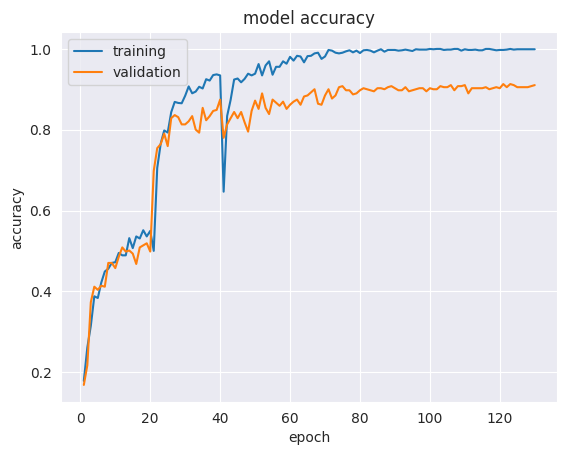

In [12]:
import matplotlib.pyplot as plt


def plot_and_save_combined_history(hists, checkpoint_dir):
    acc = []
    val_acc = []

    for hist in hists:
        acc += hist.history["accuracy"]
        val_acc += hist.history["val_accuracy"]

    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, label="training")
    plt.plot(epochs, val_acc, label="validation")
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(loc="upper left")

    plt.savefig(str(checkpoint_dir / 'training_history.png'))

    plt.show()


plot_and_save_combined_history(training_histories, checkpoint_dir)

In [13]:
import csv


def save_training_history_csv(hists, checkpoint_dir):
    acc = []
    val_acc = []
    for hist in hists:
        acc.extend(hist.history["accuracy"])
        val_acc.extend(hist.history["val_accuracy"])

    epochs = range(1, len(acc) + 1)

    # CSV-Datei schreiben
    with (checkpoint_dir / 'training_history.csv').open(mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['epoch', 'accuracy', 'val_accuracy'])
        for epoch, accuracy, val_accuracy in zip(epochs, acc, val_acc):
            writer.writerow([epoch, accuracy, val_accuracy])


save_training_history_csv(training_histories, checkpoint_dir)

In [14]:
best_checkpoint = str(checkpoint_dir / "best_model_phase_5.keras")
model = load_model(best_checkpoint)

In [15]:
print('\n---TEST SET---')
test_set = keras.preprocessing.image_dataset_from_directory(test_set_path,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMAGE_SIZE,
                                                            shuffle=False)
compute_class_frequencies(test_set_path)



---TEST SET---
Found 392 files belonging to 7 classes.
0 - Neutral   :       56 images
1 - Happy     :       56 images
2 - Sad       :       56 images
3 - Surprise  :       56 images
4 - Fear      :       56 images
5 - Disgust   :       56 images
6 - Anger     :       56 images


{0: 56, 1: 56, 2: 56, 3: 56, 4: 56, 5: 56, 6: 56}

In [16]:
test_loss, test_acc = model.evaluate(test_set)
print(f"Test accuracy: {test_acc}")

13/13 [==============================] - 2s 26ms/step - loss: 0.9144 - accuracy: 0.8648
Test accuracy: 0.8647959232330322


In [17]:
import numpy as np
from sklearn.metrics import classification_report

y_pred_vectors = model.predict(test_set)
y_pred = np.argmax(y_pred_vectors, axis=1)
y_true = np.concatenate([y for _, y in test_set], axis=0)

report = classification_report(y_true, y_pred, target_names=id_to_emotion.values(), digits=4)
print(report)

13/13 [==============================] - 2s 22ms/step
              precision    recall  f1-score   support

     Neutral     0.9123    0.9286    0.9204        56
       Happy     1.0000    0.9821    0.9910        56
         Sad     0.9302    0.7143    0.8081        56
    Surprise     0.8462    0.9821    0.9091        56
        Fear     0.8667    0.6964    0.7723        56
     Disgust     0.7500    0.9643    0.8437        56
       Anger     0.8000    0.7857    0.7928        56

    accuracy                         0.8648       392
   macro avg     0.8722    0.8648    0.8625       392
weighted avg     0.8722    0.8648    0.8625       392


[[52  0  0  0  1  0  3]
 [ 0 55  0  0  0  0  1]
 [ 2  0 40  1  3  9  1]
 [ 1  0  0 55  0  0  0]
 [ 0  0  2  9 39  1  5]
 [ 0  0  1  0  0 54  1]
 [ 2  0  0  0  2  8 44]]


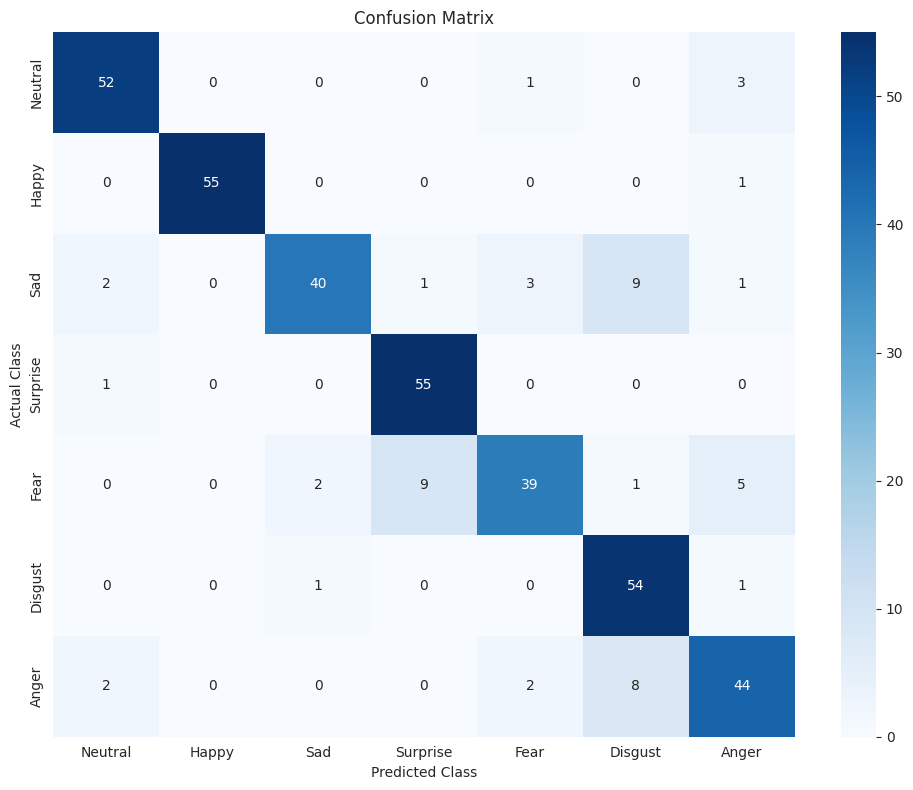

In [18]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


def plot_confusion_matrix(y_true, y_pred):
    class_names = id_to_emotion.values()

    cm = confusion_matrix(y_true, y_pred)
    print(cm)

    fig = plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Class')
    plt.ylabel('Actual Class')
    plt.tight_layout()
    plt.show()

    return fig


cm_figure = plot_confusion_matrix(y_true, y_pred)


In [19]:
def save_evaluation_results(report, cm_figure, checkpoint_dir):
    with (checkpoint_dir / 'classification_report.txt').open(mode='w') as f:
        f.write(report)
    cm_figure.savefig(str(checkpoint_dir / 'confusion_matrix.png'))


save_evaluation_results(report, cm_figure, checkpoint_dir)

In [20]:
import shutil

path_to_this_notebook = Path('/home/thor/Desktop/repos/emoji-hero-baseline/kdef_transfer_imagenet.ipynb')

shutil.copy2(path_to_this_notebook, (checkpoint_dir / path_to_this_notebook.name))

PosixPath('kdef_transfer_imagenet_20240320-1344/kdef_transfer_imagenet.ipynb')